## Funder network data
This notebook goes through the steps of processing, generating, analyzing, and visualizing data around the funder ecosystem that the Robert Sterling Clark Foundation is a part of. The purpose is to better understand the ecosystem, how it is evolving over time, and provide information to grantee partners about the wider ecosystem and its players.

We used a combination of data available via the Impala database and IRS Form 990 data available via the [ProPublica Nonprofit Explorer API](https://projects.propublica.org/nonprofits/api). We use data from Impala to obtain the most recent IRS data, and data from ProPublica to obtain historical data, as the database hadn't been updated.

Because Impala's database is not publicly available, we won't provide the associated data to reproduce this example notebook. Data should be placed in a data/ directory and referenced as such throughout.

Requirements:
- Install the necessary packages using your chosen package manager. We provide a simple requirements.txt
- An OpenAI API key, which can be obtained from 

In [2]:
# Import requirements
import requests
import fuzzywuzzy
import pandas as pd
from rapidfuzz import process, fuzz
from matplotlib import pyplot as plt
import numpy as np
import squarify
import textwrap
import xml.etree.ElementTree as ET
import os
import zipfile
from openai import OpenAI
from pydantic import BaseModel
from dotenv import load_dotenv
import math

load_dotenv() # Load API key(s)
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")


In [3]:
# UTILITIES
def convert_money_string(s):
    if pd.isna(s):
        return None
    s = s.replace('$', '').strip()
    if s.endswith('M'):
        return int(float(s[:-1]) * 1_000_000)
    elif s.endswith('K'):
        return int(float(s[:-1]) * 1_000)
    elif s.endswith('B'):
        return int(float(s[:-1]) * 1_000_000_000)
    else:
        return int(float(s))  # in case it's just a number without suffix


### Import funder network data from Impala
Here we import funders which also fund grantee-partners of the Robert Sterling Clark Foundation from the Impala database, but this could be a replaced by any dataset of funders of interest.

We use two separate datasets - one manually aggregated, curated list, and one list auto-generated by the Impala database, which shows funders who share grantee-partners with RSCF.

We will use the combined datasets for metadata generation. Overlap analysis is enabled by the auto-generated list, so only funders in the Impala generated list will appear in that visualization.

In [20]:
# Manually aggregated, reviewed list
reviewed_nyc_funder_data = pd.read_excel("data/RSCF_NYC_FUNDERS.xlsx")[['Funder', 'Location', 'State', 'Total Assets', 'Operating Budget',
       'Contributions Given', 'Median Grant Given', 'Contributions Received',
       'Funders', 'Total Staff']] # Read in if needed
print(f"Reviewed funders: {len(reviewed_nyc_funder_data)}")
reviewed_nyc_funder_data.head()

Reviewed funders: 83


,Funder,Location,State,Total Assets,Operating Budget,Contributions Given,Median Grant Given,Contributions Received,Funders,Total Staff
0,ALAN & HOPE WINTERS FAMILY FOUNDATION,NEW YORK,NY,0.0,30900.0,5700000.0,5000.0,NaN,-,0
1,THE A WOODNER FUND INC,NEW YORK,NY,3800.0,3600.0,660000.0,8000.0,NaN,-,0
2,THE RUDIN FOUNDATION INC,NEW YORK,NY,8500.0,11700.0,NaN,NaN,NaN,-,20
3,MAY AND SAMUEL RUDIN FAMILY FOUNDATION INC,NEW YORK,NY,75200.0,309600.0,4500000.0,10000.0,NaN,-,11
4,SHELLEY & DONALD RUBIN FOUNDATION,NEW YORK,NY,218200.0,577800.0,NaN,NaN,NaN,-,4


In [21]:
# Impala generated list
# Import funders with overlapping grantee-partners
impala_cofunders = pd.read_csv('data/overlapping_funders.csv').drop(columns = "#")
impala_cofunders['Co-Funder'] = impala_cofunders['Co-Funder'].str.split('\n').str[0]
impala_cofunders = impala_cofunders[impala_cofunders["Funded Nonprofits"] > 4] # For these purposes, drop any funders with 4 or less overlapping grantee partners

# Apply to the column
impala_cofunders['Combined Funding'] = impala_cofunders['Combined Funding'].apply(convert_money_string)

# Display first few rows
print(f"Impala co-funders: {len(impala_cofunders)}")
impala_cofunders.head()

Impala co-funders: 207


,Co-Funder,Funded Nonprofits,Combined Funding
0,THE FORD FOUNDATION,42,87700000
1,Amalgamated Charitable Foundation Inc,32,29700000
2,Rockefeller Philanthropy Advisors Inc,28,29500000
3,WELLSPRING PHILANTHROPIC FUND INC,26,31200000
4,NEW YORK WOMEN'S FOUNDATION INC,25,3900000


In [22]:
# Combined datasets
reviewed_nyc_funder_data = reviewed_nyc_funder_data.rename(columns = {"Funder": "Co-Funder"})
cofunders = pd.merge(reviewed_nyc_funder_data, impala_cofunders, how="outer", on="Co-Funder")
print(f"Combined funders: {len(cofunders)}")
cofunders.head()

Combined funders: 269


,Co-Funder,Location,State,Total Assets,Operating Budget,Contributions Given,Median Grant Given,Contributions Received,Funders,Total Staff,Funded Nonprofits,Combined Funding
0,AARP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,349000.0
1,ABNY FOUNDATION INC,NEW YORK,NY,2100000.0,215700.0,200000.0,10000.0,129000.0,4,1,NaN,NaN
2,ALAN & HOPE WINTERS FAMILY FOUNDATION,NEW YORK,NY,0.0,30900.0,5700000.0,5000.0,NaN,-,0,NaN,NaN
3,ALFRED P SLOAN FOUNDATION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,5000000.0
4,ALTMAN FOUNDATION,NEW YORK,NY,283300000.0,6500000.0,12600000.0,50000.0,NaN,-,13,12.0,4200000.0


### Get organization data
We use LLMs to search the web to enrich the information we have available. Specifically, we are looking for a geographic focus (NYC) and for a programmatic focus on leadership development. We also check for whether or not they accept unsolicited proposals.

In [24]:
from openai import OpenAI
from pydantic import BaseModel

# Define the structured output model
class FunderMetadata(BaseModel):
    geo_focus: str
    geo_focus_citation: list[str]
    lead_dev_focus: str
    lead_dev_citation: list[str]
    accept_loi: str
    accept_loi_citation: list[str]

def research_funder(funder: str) -> FunderMetadata:
    """
    Use OpenAI web search to identify a funder's geographic and programmatic areas of focus,
    and whether they accept unsolicited proposals (LOIs).
    """
    client = OpenAI(api_key=OPENAI_API_KEY)

    response = client.responses.parse(
        model="gpt-4o-mini-2024-07-18",
        tools=[{"type": "web_search"}],
        text_format=FunderMetadata,  
        input=[
            {
                "role": "system",
                "content": (
                    "You are a research assistant that identifies information about philanthropic organizations "
                    "from trusted web sources such as official websites, GuideStar, and ProPublica. "
                    "You should prioritize official and reputable data sources, specifically the organization's own website and communications."
                ),
            },
            {
                "role": "user",
                "content": f"""
                Find the following information for the organization "{funder}":
                - Geographic area(s) of grantmaking focus. 
                - Whether they have a focus on leadership development or civic engagement
                - Whether they accept letters of interest (LOIs) or unsolicited proposals
                - For each of these, provide the URL or URLs that you sourced this information from

                If no information is found for geographic focus, the result should be 'None'.

                Return the information as a JSON object with the following fields:
                {{
                    "geo_focus": "<geographic area(s)>",
                    "geo_focus_citation": [url1]
                    "lead_dev_focus": <true/false>,
                    "lead_dev_citation": [url1, url2]
                    "accept_loi": <true/false>,
                    "accept_loi_citation": [url1]
                }}
                """
            }
        ]
    )

    # The structured response will be parsed directly into the model
    return response.output_parsed


In [36]:
def enrich_cofunder_metadata(cofunders: pd.DataFrame) -> pd.DataFrame:
    # Initialize empty lists to store results
    geo_focus_list = []
    lead_dev_focus_list = []
    accept_loi_list = []

    for funder in cofunders["Co-Funder"]:
        print(f"Processing {funder}")
        try:
            metadata = research_funder(funder)
            
            if metadata.geo_focus == 'None':
                geo_focus_list.append(None)
            else:
                geo_focus_list.append(metadata.geo_focus)
            if metadata.lead_dev_focus == 'None':
                lead_dev_focus_list.append(None)
            else:
                lead_dev_focus_list.append(metadata.lead_dev_focus)
            if metadata.accept_loi == 'None':
                accept_loi_list.append(None)
            else:
                accept_loi_list.append(metadata.accept_loi)

            
        except Exception as e:
            print(f"Error processing {funder}: {e}")
            geo_focus_list.append(None)
            lead_dev_focus_list.append(None)
            accept_loi_list.append(None)

    # Add new columns to the DataFrame
    cofunders["geo_focus"] = geo_focus_list
    cofunders["lead_dev_focus"] = lead_dev_focus_list
    cofunders["accept_loi"] = accept_loi_list

    return cofunders

cofunders = enrich_cofunder_metadata(cofunders)
print(cofunders.head())


Processing AARP


c:\Users\laura\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydantic\main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `literal['file_search']` - serialized value may not be as expected [input_value='web_search', input_type=str])
  PydanticSerializationUnexpectedValue(Expected `FunctionTool` - serialized value may not be as expected [input_value=FileSearchTool(type='web_...None, 'timezone': None}), input_type=FileSearchTool])
  PydanticSerializationUnexpectedValue(Expected `ComputerTool` - serialized value may not be as expected [input_value=FileSearchTool(type='web_...None, 'timezone': None}), input_type=FileSearchTool])
  PydanticSerializationUnexpectedValue(Expected `WebSearchTool` - serialized value may not be as expected [input_value=FileSearchTool(type='web_...None, 'timezone': None}), input_type=FileSearchTool])
  return self.__pydantic_serializer__.to_python(


Processing ABNY FOUNDATION INC
Processing ALAN & HOPE WINTERS FAMILY FOUNDATION
Processing ALFRED P SLOAN FOUNDATION
Processing ALTMAN FOUNDATION
Processing AMERICAN COUNCIL OF LEARNED SOCIETIES
Processing AMERICAN EXPRESS FOUNDATION
Processing ARC OF JUSTICE
Processing ARCUS FOUNDATION
Processing ARIE AND IDA CROWN MEMORIAL
Processing Amalgamated Charitable Foundation Inc
Processing Annie E Casey Foundation Inc
Processing BAIRD FOUNDATION INC
Processing BEN & JERRY'S FOUNDATION INC
Processing BERNARD AND ANNE SPITZER CHARITABLE TRUST
Processing BILL & MELINDA GATES FOUNDATION
Processing BLUE MERIDIAN PARTNERS INC
Processing BOOTH FERRIS FOUNDATION XXXXX4008
Processing BOREALIS PHILANTHROPY
Processing BREAD AND ROSES COMMUNITY FUND
Processing BROOKLYN COMMUNITY FOUNDATION
Processing Barr Foundation
Processing Boston Foundation, Inc
Processing CALIFORNIA COMMUNITY FOUNDATION
Processing CALIFORNIA HEALTHCARE FOUNDATION
Processing CALIFORNIA PHYSICIANS' SERVICE FDN DBA BLUE SHIELD OF CALI

In [41]:
# If info not available, for geo_focus, assign to NY if their location is in NY and review manually
for i, row in cofunders.iterrows():
    if row["geo_focus"] == None:
        if str(row["Location"]).lower() == "new york":
            cofunders.loc[i, "geo_focus"] = "New York"
            print("Changed geographic focus column")

In [42]:
# Create NYC focus filter
contains_nyc = cofunders['nyc_focus'] = cofunders['geo_focus'].str.contains(r'\b(NYC|Manhattan|Bronx|Queens|Brooklyn|Staten Island|New York)\b', case=False, na=False)

# Create national focus filter
contains_national = cofunders['geo_focus'].str.contains(r'\b(national|United States|US)\b', case=False, na=False)

cofunders['nyc_focus'] = np.where(contains_nyc, True, False)
cofunders['national_focus'] = contains_national
print(f"Number focused on NYC: {cofunders['nyc_focus'].sum()}")
cofunders.head()

Number focused on NYC: 80


C:\Users\laura\AppData\Local\Temp\ipykernel_28804\2544535593.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_nyc = cofunders['nyc_focus'] = cofunders['geo_focus'].str.contains(r'\b(NYC|Manhattan|Bronx|Queens|Brooklyn|Staten Island|New York)\b', case=False, na=False)
C:\Users\laura\AppData\Local\Temp\ipykernel_28804\2544535593.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_national = cofunders['geo_focus'].str.contains(r'\b(national|United States|US)\b', case=False, na=False)


,Co-Funder,Location,State,Total Assets,Operating Budget,Contributions Given,Median Grant Given,Contributions Received,Funders,Total Staff,Funded Nonprofits,Combined Funding,geo_focus,lead_dev_focus,accept_loi,nyc_focus,national_focus
0,AARP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,349000.0,"United States, Puerto Rico, U.S. Virgin Islands",NaN,true,False,True
1,ABNY FOUNDATION INC,NEW YORK,NY,2100000.0,215700.0,200000.0,10000.0,129000.0,4,1,NaN,NaN,New York City,NaN,No,True,False
2,ALAN & HOPE WINTERS FAMILY FOUNDATION,NEW YORK,NY,0.0,30900.0,5700000.0,5000.0,NaN,-,0,NaN,NaN,New York,NaN,NaN,True,False
3,ALFRED P SLOAN FOUNDATION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,5000000.0,United States,NaN,true,False,True
4,ALTMAN FOUNDATION,NEW YORK,NY,283300000.0,6500000.0,12600000.0,50000.0,NaN,-,13,12.0,4200000.0,"New York City, New York State",NaN,true,True,False


In [ ]:
# Optionally save CSV at this step
# This CSV includes additional information surfaced about funders (geographic focus, whether or not they have leadership dev/civic engagement focused program areas, 
# whether they accept unsolicited proposals or LOIs)
cofunders.to_csv("data/RSCF_OVERLAPPING_FUNDERS.csv", index=False)

In [99]:
# Get only NYC overlapping funders
cofunders = pd.read_csv("data/RSCF_OVERLAPPING_FUNDERS.csv")
ny_cofunders = cofunders[cofunders["nyc_focus"] == True].reset_index(drop=True)
print(f"NYC only co-funders: {ny_cofunders}")

NYC only co-funders:                                             Co-Funder  Location State  \
0                                 ABNY FOUNDATION INC  NEW YORK    NY   
1               ALAN & HOPE WINTERS FAMILY FOUNDATION  NEW YORK    NY   
2                                   ALTMAN FOUNDATION  NEW YORK    NY   
3           BERNARD AND ANNE SPITZER CHARITABLE TRUST  NEW YORK    NY   
4                       BROOKLYN COMMUNITY FOUNDATION  BROOKLYN    NY   
..                                                ...       ...   ...   
75         The Harry and Jeanette Weinberg Foundation       NaN   NaN   
76                       The New York Community Trust  New York    NY   
77                        UNITED WAY OF NEW YORK CITY  NEW YORK    NY   
78  United Jewish Appeal - Federation Of Jewish Ph...  NEW YORK    NY   
79                       VAN AMERINGEN FOUNDATION INC  NEW YORK    NY   

    Total Assets  Operating Budget  Contributions Given  Median Grant Given  \
0   2.100000e+06       

In [100]:
# Get only those in the manual dataset
reviewed_nyc_funder_data_enriched = ny_cofunders
print(f"NYC funders enriched: {len(reviewed_nyc_funder_data_enriched)}")
reviewed_nyc_funder_data_enriched.head()

NYC funders enriched: 80


,Co-Funder,Location,State,Total Assets,Operating Budget,Contributions Given,Median Grant Given,Contributions Received,Funders,Total Staff,Funded Nonprofits,Combined Funding,geo_focus,lead_dev_focus,accept_loi,nyc_focus,national_focus
0,ABNY FOUNDATION INC,NEW YORK,NY,2100000.0,215700.0,200000.0,10000.0,129000.0,4,1,NaN,NaN,New York City,NaN,No,True,False
1,ALAN & HOPE WINTERS FAMILY FOUNDATION,NEW YORK,NY,0.0,30900.0,5700000.0,5000.0,NaN,-,0,NaN,NaN,New York,NaN,NaN,True,False
2,ALTMAN FOUNDATION,NEW YORK,NY,283300000.0,6500000.0,12600000.0,50000.0,NaN,-,13,12.0,4200000.0,"New York City, New York State",NaN,true,True,False
3,BERNARD AND ANNE SPITZER CHARITABLE TRUST,NEW YORK,NY,679100000.0,18700000.0,39800000.0,25000.0,NaN,-,7,NaN,NaN,"New York, Washington, D.C., California",NaN,False,True,False
4,BROOKLYN COMMUNITY FOUNDATION,BROOKLYN,NY,124200000.0,4600000.0,14400000.0,25000.0,4600000.0,42,5,16.0,2500000.0,"Brooklyn, New York",NaN,NaN,True,False


#### Create treemap visualization of grantee-partner overlap with other funders and the Foundation 


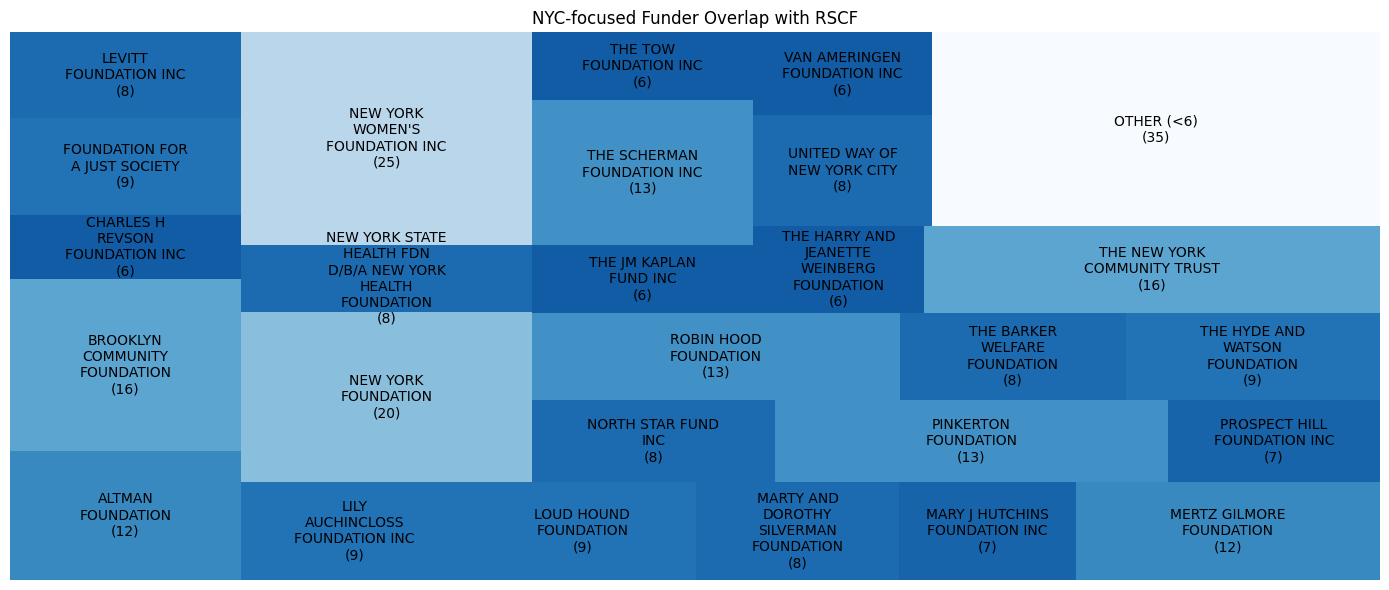

In [78]:
# Create a mask for overlap of 5 or less nonprofits, based on substantial overlapping grantees
ny_cofunders["Funded Nonprofits"] = ny_cofunders["Funded Nonprofits"].astype('Int64')
ny_cofunders = ny_cofunders[~ny_cofunders["Funded Nonprofits"].isna()] # Drop out those that were only in the manually curated dataset
mask = ny_cofunders["Funded Nonprofits"] < 6

# Sum up all below-5 values
other_sum = ny_cofunders.loc[mask, "Funded Nonprofits"].sum()

# Keep only rows >= 5
df_filtered = ny_cofunders.loc[~mask].copy()
other_row = pd.DataFrame({
    "Co-Funder": ["Other (<6)"],
    "Funded Nonprofits": [other_sum]
})

# Append "Other" row
df_filtered = pd.concat([df_filtered, other_row], ignore_index=True)
df_filtered["Co-Funder"] = df_filtered["Co-Funder"].apply(lambda x: x.upper())

# Plot treemaps
fig, axes = plt.subplots(figsize=(14, 6))

def wrap_label(name, value, width=15): # Adjust text wrapping here as needed
    wrapped_name = "\n".join(textwrap.wrap(name, width=width))
    return f"{wrapped_name}\n({value})"

# Create wrapped labels with values
labels = [
    wrap_label(row["Co-Funder"], row["Funded Nonprofits"])
    for _, row in df_filtered.iterrows()
]

# NY Treemap
squarify.plot(
    sizes=df_filtered["Funded Nonprofits"],
    label=labels,
    ax=axes,
    color=plt.cm.Blues_r(df_filtered["Funded Nonprofits"] / max(df_filtered["Funded Nonprofits"])),
    pad=0,
    text_kwargs={'fontsize': 10}
)
axes.set_title("NYC-focused Funder Overlap with RSCF")
axes.axis('off')

# Final layout
plt.tight_layout()
plt.show()

In [13]:
# Non-NY Treemap
# Uncomment for visualizing tree map of funders without a primary NYC focus
nonny_cofunders = cofunders[~cofunders["Co-Funder"].isin(cofunders)]

# Plot treemaps
# fig, axes = plt.subplots(figsize=(14, 6))

# def wrap_label(name, value, width=15):
#     wrapped_name = "\n".join(textwrap.wrap(name, width=width))
#     return f"{wrapped_name}\n({value})"

# # Create wrapped labels with values
# labels = [
#     wrap_label(row["Co-Funder"], row["Funded Nonprofits"])
#     for _, row in df_filtered.iterrows()
# ]
# squarify.plot(
#     sizes=nonny_cofunders["Combined Funding"],
#     label=nonny_cofunders["Co-Funder"],
#     ax=axes,
#     color=plt.cm.Greens_r(nonny_cofunders["Combined Funding"] / max(nonny_cofunders["Combined Funding"])),
#     pad=True
# )
# axes.set_title("Non-NYC-focused Funder Overlap with RSCF")
# axes.axis('off')

# # Final layout
# plt.tight_layout()
# plt.show()

### Get 990 data via ProPublica API

#### Match names with IRS funder names
Due to issues with matching funder names to IRS filed names, we asked an LLM to suggest IRS-friendly alternative names to search the ProPublica API with. This resulted in almost 20% more matches.

In [101]:
suggested_names = pd.read_csv("data/suggested_names.csv")
alt_names = suggested_names["Suggested IRS-Friendly Alternative"]
reviewed_nyc_funder_data_enriched = pd.merge(reviewed_nyc_funder_data_enriched, suggested_names, left_on="Co-Funder", right_on="Original Name", how="left").drop(columns=["Original Name"]).rename(columns = {"Suggested IRS-Friendly Alternative":"alt_name"})
reviewed_nyc_funder_data_enriched["alt_name"] = reviewed_nyc_funder_data_enriched["alt_name"].astype(str)
for i, r in reviewed_nyc_funder_data_enriched.iterrows():
    if r["alt_name"] == "nan":
        reviewed_nyc_funder_data_enriched.loc[i, "alt_name"] = r["Co-Funder"]
reviewed_nyc_funder_data_enriched.head()

,Co-Funder,Location,State,Total Assets,Operating Budget,Contributions Given,Median Grant Given,Contributions Received,Funders,Total Staff,Funded Nonprofits,Combined Funding,geo_focus,lead_dev_focus,accept_loi,nyc_focus,national_focus,Unnamed: 0,alt_name
0,ABNY FOUNDATION INC,NEW YORK,NY,2100000.0,215700.0,200000.0,10000.0,129000.0,4,1,NaN,NaN,New York City,NaN,No,True,False,11.0,Abny Foundation Inc
1,ALAN & HOPE WINTERS FAMILY FOUNDATION,NEW YORK,NY,0.0,30900.0,5700000.0,5000.0,NaN,-,0,NaN,NaN,New York,NaN,NaN,True,False,0.0,Winters Family Foundation
2,ALTMAN FOUNDATION,NEW YORK,NY,283300000.0,6500000.0,12600000.0,50000.0,NaN,-,13,12.0,4200000.0,"New York City, New York State",NaN,true,True,False,60.0,Altman Foundation
3,BERNARD AND ANNE SPITZER CHARITABLE TRUST,NEW YORK,NY,679100000.0,18700000.0,39800000.0,25000.0,NaN,-,7,NaN,NaN,"New York, Washington, D.C., California",NaN,False,True,False,71.0,Bernard And Anne Spitzer Charitable Tr
4,BROOKLYN COMMUNITY FOUNDATION,BROOKLYN,NY,124200000.0,4600000.0,14400000.0,25000.0,4600000.0,42,5,16.0,2500000.0,"Brooklyn, New York",NaN,NaN,True,False,48.0,Brooklyn Community Foundation


#### ProPublica API queries for Form 990 data
First, we query by organization name to find their EINs.
Then, we query by EIN to obtain 990 data.

In [102]:
# Create API queries to obtain organization EINs for search
params = []

# Try with alternate names
for i, r in reviewed_nyc_funder_data_enriched.iterrows():
    params.append({"q": reviewed_nyc_funder_data_enriched.loc[i,'alt_name'],"state[id]": reviewed_nyc_funder_data_enriched.loc[i,'State']})

params[0:10]

url = "https://projects.propublica.org/nonprofits/api/v2/search.json"

data = []

for param in params:
    response = requests.get(url, params=param)
    data.append(response.json()["organizations"])

# Check status
print(response.status_code)

# View start of JSON data
print(data[0:100])

200
[[{'ein': 133601266, 'strein': '13-3601266', 'name': 'Abny Foundation Inc', 'sub_name': 'Abny Foundation Inc', 'city': 'New York', 'state': 'NY', 'ntee_code': 'T22', 'raw_ntee_code': 'T22', 'subseccd': 3, 'has_subseccd': True, 'have_filings': None, 'have_extracts': None, 'have_pdfs': None, 'score': 112.533936}], [{'ein': 526775755, 'strein': '52-6775755', 'name': 'Alan And Hope Winters Family Foundation', 'sub_name': 'Alan And Hope Winters Family Foundation', 'city': 'New York', 'state': 'NY', 'ntee_code': None, 'raw_ntee_code': None, 'subseccd': 3, 'has_subseccd': True, 'have_filings': None, 'have_extracts': None, 'have_pdfs': None, 'score': 78.42038}], [{'ein': 131623879, 'strein': '13-1623879', 'name': 'Altman Foundation', 'sub_name': 'Altman Foundation', 'city': 'New York', 'state': 'NY', 'ntee_code': None, 'raw_ntee_code': None, 'subseccd': 3, 'has_subseccd': True, 'have_filings': None, 'have_extracts': None, 'have_pdfs': None, 'score': 90.81021}, {'ein': 133944577, 'strein': 

In [205]:
# Get all orgs returned
names = []
for org in data:
    for result in org:
        names.append(result["name"])
        
# Fuzzy search to match funders surfaced via ProPublica calls to our funder list and filter list
matching_funders = []
name_check = pd.DataFrame()
names_cleaned =  [s.replace("Foundation", "").lower() for s in names] 
names_df = pd.DataFrame({"names": names, "names_clean": names_cleaned})

for funder in reviewed_nyc_funder_data_enriched["alt_name"]:
    cleaned_funder = funder.replace("Foundation", "") # Try matching without 'foundation'
    match = process.extractOne(cleaned_funder.lower(), names_df["names_clean"], score_cutoff = 75, scorer=fuzz.partial_ratio)
    if match:
        match = match[0]
        match_name = str(names_df.loc[names_df["names_clean"] == match, "names"].values[0])
    name_check_row = pd.DataFrame([{"Funder": funder, "Match": match_name}])
    name_check = pd.concat([name_check, name_check_row])
    matching_funders.append(match_name)

print(f"Funders matched: {len(set(matching_funders))}")
# Export as a CSV to inspect
name_check.to_csv("data/name_check.csv", index=False)

Funders matched: 69


In [220]:
# # After manual inspection, we manually change a few names which are incorrect and read back in - 
name_check = pd.read_csv("data/name_check.csv")

In [221]:
# Get all matching funders from API search
filtered_funders = []
matched_filtered = []

for org in data: # for each org searched for
    for result in org: # for every org returned
        if result["name"] in matching_funders:
            matched_filtered.append(result["name"])
            filtered_funders.append(result)

print(f"Funders in original list: {len(reviewed_nyc_funder_data_enriched)}")
print(f"Funders from ProPublica matching original list: {len(filtered_funders)}")

# Remove duplicates
check_df = pd.DataFrame(matched_filtered, columns = ["Funder"])
filtered_funders = pd.DataFrame(filtered_funders)
filtered_funders = filtered_funders[~check_df.duplicated()]
print(f"Funders after deduplication: {len(filtered_funders)}")

Funders in original list: 80
Funders from ProPublica matching original list: 74
Funders after deduplication: 69


In [222]:
# Get all organization EINS and associated 990 data
eins = []

# Get EINS
for i, org in filtered_funders.iterrows():
        eins.append(org["ein"])

# Query ProPublica API for 990 data for each org
irs_data = []
for ein in eins:
    url = f"https://projects.propublica.org/nonprofits/api/v2/organizations/{ein}.json"
    response = requests.get(url).json()
    irs_data.append(response)

print(irs_data[0:5])

[{'organization': {'id': 133601266, 'ein': 133601266, 'name': 'Abny Foundation Inc', 'careofname': '% ASSOCIATION FOR A BETTER NEW YORK', 'address': '825 EIGHTH AVENUE 35TH FLOOR', 'city': 'New York', 'state': 'NY', 'zipcode': '10019-7446', 'exemption_number': 0, 'subsection_code': 3, 'affiliation_code': 3, 'classification_codes': '1000', 'ruling_date': '1991-05-01', 'deductibility_code': 1, 'foundation_code': 15, 'activity_codes': '927995404', 'organization_code': 1, 'exempt_organization_status_code': 1, 'tax_period': '2023-12-01', 'asset_code': 6, 'income_code': 5, 'filing_requirement_code': 1, 'pf_filing_requirement_code': 0, 'accounting_period': 12, 'asset_amount': 2111262, 'income_amount': 677144, 'revenue_amount': 382348, 'ntee_code': 'T22', 'sort_name': None, 'created_at': '2023-05-09T20:23:25.533Z', 'updated_at': '2025-09-19T17:05:37.187Z', 'data_source': 'current_2025_09_19', 'have_extracts': None, 'have_pdfs': None, 'latest_object_id': '202413029349301481'}, 'filings_with_dat

### Create dataframe of contributions paid for each organization and year
Here we work directly with tax_prd_yr, which represents the tax period of the filing. In lieu of more granular (disbursement date) these are assumed to represent the same year, although there may be some mismatch of tax year schedule. 

In [223]:
funder_irs = pd.DataFrame(irs_data)
org_df = funder_irs['organization'].apply(pd.Series)
info_990 = funder_irs['filings_with_data'].apply(pd.Series)

# This part is messed up, trying to get pdfs link
without_data = funder_irs.explode('filings_without_data').reset_index(drop=True)
without_filings_df = pd.json_normalize(without_data['filings_with_data'])
funder_irs_pdfs = pd.concat([without_data.drop(columns=['filings_with_data']), without_filings_df], axis=1)

# Combine it back with the original dataframe (dropping the nested column)
funder_irs = pd.concat([org_df, funder_irs.drop(columns=['organization'])], axis=1).drop(columns = ["data_source"])

df_exploded = funder_irs.explode('filings_with_data').reset_index(drop=True)

# Convert the dicts in 'filings_with_data' into separate columns
filings_df = pd.json_normalize(df_exploded['filings_with_data'])

# Combine with the rest of the original data (drop the now-unpacked column)
funder_irs = pd.concat([df_exploded.drop(columns=['filings_with_data']), filings_df], axis=1)

funder_spending = funder_irs[["name", "ein", "tax_period","tax_prd_yr","contrpdpbks"]]
funder_spending["contributions"] = funder_spending["contrpdpbks"]

funder_spending

C:\Users\laura\AppData\Local\Temp\ipykernel_27780\2597480942.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funder_spending["contributions"] = funder_spending["contrpdpbks"]


,name,ein,ein,tax_period,tax_prd_yr,contrpdpbks,contributions
0,Abny Foundation Inc,133601266,133601266,2023-12-01,2023,NaN,NaN
1,Abny Foundation Inc,133601266,133601266,2023-12-01,2022,NaN,NaN
2,Abny Foundation Inc,133601266,133601266,2023-12-01,2021,NaN,NaN
3,Abny Foundation Inc,133601266,133601266,2023-12-01,2020,NaN,NaN
4,Abny Foundation Inc,133601266,133601266,2023-12-01,2019,NaN,NaN
...,...,...,...,...,...,...,...
691,Van Ameringen Foundation Inc,136125699,136125699,2023-12-01,2015,5046941.0,5046941.0
692,Van Ameringen Foundation Inc,136125699,136125699,2023-12-01,2014,4613641.0,4613641.0
693,Van Ameringen Foundation Inc,136125699,136125699,2023-12-01,2013,3848500.0,3848500.0
694,Van Ameringen Foundation Inc,136125699,136125699,2023-12-01,2012,3800400.0,3800400.0


#### Add 2024 data from Impala

In [224]:
# Data from Impala is understood to be reported as Contributions Given on tax return basis 
funder_spending_merged = pd.merge(funder_spending,name_check, left_on= "name", right_on = "Match",how = "left") # Name check contains Impala names
funder_spending_merged = pd.merge(reviewed_nyc_funder_data_enriched[["Co-Funder", "alt_name", "Contributions Given","Median Grant Given", "geo_focus", "lead_dev_focus", "accept_loi"]], funder_spending_merged, left_on="alt_name", right_on ="Funder")
funder_spending_merged = funder_spending_merged.drop(columns = ["Funder", "alt_name", "Match"])

# Remove duplicate columns
funder_spending_merged = funder_spending_merged.loc[:, ~funder_spending_merged.columns.duplicated(keep='first')]
print(f"Rows before merge: {len(funder_spending)}")
print(f"De-duplicated rows after horizontal merge with 2024 data {len(funder_spending_merged)}")

# Store all new rows in a list
new_rows = []

for funder in funder_spending_merged["name"].dropna().unique():
    try:
        subset = funder_spending_merged[funder_spending_merged["name"] == funder]
        
        new_row = {
            "name": funder,
            "Median Grant Given": subset["Median Grant Given"].iloc[0],
            "Geographic focus": subset["geo_focus"].iloc[0],
            "Leadership dev/civic engagement focus": subset["lead_dev_focus"].iloc[0],
            "Accepts LOIs": subset["accept_loi"].iloc[0],
            "ein": subset["ein"].iloc[0],
            "tax_prd_yr": 2024,
            "contributions": subset["Contributions Given"].iloc[0]
        }
        new_rows.append(new_row)
        
    except IndexError:
        # Skip if something is missing
        continue

# Create a DataFrame with 2023 rows
df_2024 = pd.DataFrame(new_rows)

# Append to the original merged dataframe
funder_spending_merged = pd.concat([funder_spending_merged, df_2024], ignore_index=True)

# Remove year duplicates
funder_spending_merged = funder_spending_merged.loc[~funder_spending_merged.duplicated(subset=["name", "tax_prd_yr"], keep='first')]

print(f"Rows after adding 2024 data as a row: {len(funder_spending_merged)}")
funder_spending_merged = funder_spending_merged.drop(index = funder_spending_merged[funder_spending_merged["contributions"]==0].index)
funder_spending_merged = funder_spending_merged.drop(index = funder_spending_merged[funder_spending_merged["contributions"].isna()].index)

funder_spending_unf = funder_spending_merged.copy()

# Check organization data availability per year
contributions_by_year = funder_spending_merged.groupby("tax_prd_yr").agg({"contributions":"sum", "name":"count"}).reset_index()
contributions_by_year

Rows before merge: 696
De-duplicated rows after horizontal merge with 2024 data 720
Rows after adding 2024 data as a row: 762


,tax_prd_yr,contributions,name
0,2011,1.839740e+08,53
1,2012,3.498015e+08,58
2,2013,3.490597e+08,58
3,2014,2.795252e+08,57
4,2015,2.564386e+08,55
5,2016,1.203207e+07,6
6,2018,2.683000e+06,1
7,2019,3.414616e+08,52
8,2020,4.279151e+08,56
9,2021,4.506274e+08,56


Here we choose representative years.

In [225]:
unique_2012 = funder_spending_merged.loc[funder_spending_merged["tax_prd_yr"] == 2012,"name"].unique()
unique_2022 = funder_spending_merged.loc[funder_spending_merged["tax_prd_yr"] == 2024,"name"].unique()

unique_2023 = funder_spending_merged.loc[funder_spending_merged["tax_prd_yr"] == 2022,"name"].unique()
funder_spending_merged = funder_spending_merged[funder_spending_merged["name"].isin(unique_2012) & funder_spending_merged["name"].isin(unique_2022) & funder_spending_merged["name"].isin(unique_2023)]
print(f"Rows after adding 2024 data as a row: {len(funder_spending_merged)}")

# Check organization data availability per year after filtering
contributions_by_year = funder_spending_merged.groupby("tax_prd_yr").agg({"contributions":"sum", "name":"count"}).reset_index()
contributions_by_year

Rows after adding 2024 data as a row: 479


,tax_prd_yr,contributions,name
0,2011,142841724.0,42
1,2012,299177335.0,44
2,2013,298757063.0,44
3,2014,230234182.0,44
4,2015,199745638.0,43
5,2016,4082570.0,2
6,2018,2683000.0,1
7,2019,261116372.0,41
8,2020,306969773.0,44
9,2021,322916941.0,44


#### Normalize by CPI-U, a commonly referenced indicator of inflation, to get chained dollar value

In [226]:
# Funding over time
contributions_by_year = funder_spending_merged.groupby("tax_prd_yr").agg({"contributions":"sum", "name":"count"}).reset_index()

# Normalize by CPI for inflation
annual_cpi_u = pd.read_excel("data/historical-cpi-u-202509.xlsx", sheet_name = "Index Averages", skiprows=[0,1,2])
annual_cpi_u_subset = annual_cpi_u[annual_cpi_u["Year"] > 2010][["Year", "Annual\navg."]].rename(columns = {"Annual\navg.":"annual_avg_cpi"})

# Real Value = Nominal Value × (Base Year CPI / Current Year CPI)
# From US Bureau of Labor Statistics - CPI - U 
contri_by_year_inf = pd.merge(contributions_by_year, annual_cpi_u_subset, left_on = "tax_prd_yr", right_on= "Year")
funder_spending_merged = pd.merge(funder_spending_merged, annual_cpi_u_subset, left_on = "tax_prd_yr", right_on= "Year")
funder_spending_unf = pd.merge(funder_spending_unf, annual_cpi_u_subset, left_on = "tax_prd_yr", right_on= "Year")

base_yr = 2023
base = contri_by_year_inf.loc[contri_by_year_inf["tax_prd_yr"]==base_yr,"annual_avg_cpi"].values
print(f"CPI in base year ({base_yr}): {base}")
contri_by_year_inf["contributions_inf"] = contri_by_year_inf["contributions"] * (base / contri_by_year_inf["annual_avg_cpi"])
funder_spending_merged["contributions_inf"] = funder_spending_merged["contributions"] * (base / funder_spending_merged["annual_avg_cpi"])
funder_spending_unf["contributions_inf"] = funder_spending_unf["contributions"] * (base / funder_spending_unf["annual_avg_cpi"])

funder_spending_merged

CPI in base year (2023): [304.702]


,Co-Funder,Contributions Given,Median Grant Given,geo_focus,lead_dev_focus,accept_loi,name,ein,tax_period,tax_prd_yr,contrpdpbks,contributions,Geographic focus,Leadership dev/civic engagement focus,Accepts LOIs,Year,annual_avg_cpi,contributions_inf
0,ALTMAN FOUNDATION,12600000.0,50000.0,"New York City, New York State",NaN,true,Altman Foundation,131623879,2023-12-01,2023,11916230.0,11916230.0,NaN,NaN,NaN,2023.0,304.702,11916230.0
1,ALTMAN FOUNDATION,12600000.0,50000.0,"New York City, New York State",NaN,true,Altman Foundation,131623879,2023-12-01,2022,14384502.0,14384502.0,NaN,NaN,NaN,2022.0,292.655,14976632.992445
2,ALTMAN FOUNDATION,12600000.0,50000.0,"New York City, New York State",NaN,true,Altman Foundation,131623879,2023-12-01,2021,12575473.0,12575473.0,NaN,NaN,NaN,2021.0,270.97,14140944.65825
3,ALTMAN FOUNDATION,12600000.0,50000.0,"New York City, New York State",NaN,true,Altman Foundation,131623879,2023-12-01,2020,13026535.0,13026535.0,NaN,NaN,NaN,2020.0,258.811,15336331.4062
4,ALTMAN FOUNDATION,12600000.0,50000.0,"New York City, New York State",NaN,true,Altman Foundation,131623879,2023-12-01,2019,10933226.0,10933226.0,NaN,NaN,NaN,2019.0,255.657,13030645.860086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,NaN,NaN,40000.0,NaN,NaN,NaN,Scherman Foundation Inc,136098464,NaN,2024,NaN,7000000.0,"New York, New Jersey, Pennsylvania, Ohio, Mich...",NaN,true,2024.0,313.689,6799454.236521
475,NaN,NaN,25000.0,NaN,NaN,NaN,The Speyer Family Foundation Inc,136158848,NaN,2024,NaN,1900000.0,"California, District of Columbia, Florida, Ill...",NaN,NaN,2024.0,313.689,1845566.149913
476,NaN,NaN,50000.0,NaN,NaN,NaN,The Tow Foundation Inc,66484045,NaN,2024,NaN,23900000.0,Connecticut and New York,NaN,false,2024.0,313.689,23215279.464693
477,NaN,NaN,5000.0,NaN,NaN,NaN,Carl Marks Foundation Inc,136169215,NaN,2024,NaN,256100.0,"New York, San Francisco, Chicago, and other ci...",NaN,NaN,2024.0,313.689,248762.889996


#### Visualize by average grantmaking budget over time

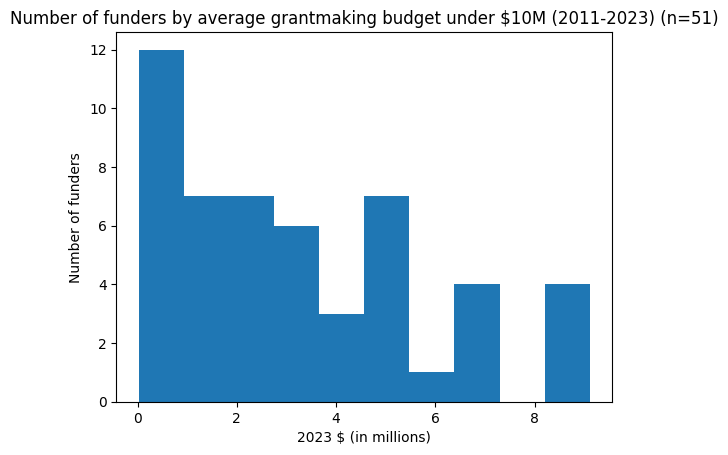

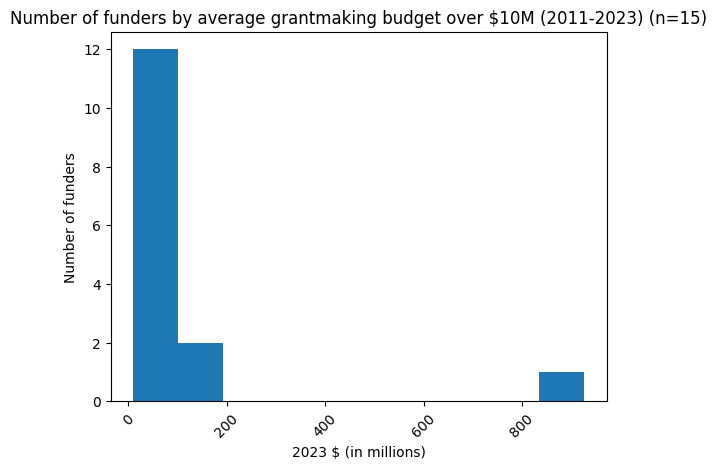

In [227]:
contributions_by_org = funder_spending_unf.groupby("name").agg({"contributions_inf":"mean"}).reset_index()
under_10m = contributions_by_org[contributions_by_org["contributions_inf"] < 10e6]
over_100m = contributions_by_org[contributions_by_org["contributions_inf"] > 10e6]

plt.hist(under_10m["contributions_inf"] / 1e6)
plt.title(f"Number of funders by average grantmaking budget under $10M (2011-2023) (n={len(under_10m)})")
plt.xlabel("Number of funders")
plt.ylabel("Number of funders")
plt.ticklabel_format(style='plain')
plt.xlabel("2023 $ (in millions)")
plt.show()

plt.hist(over_100m["contributions_inf"] / 1e6)
plt.title(f"Number of funders by average grantmaking budget over $10M (2011-2023) (n={len(over_100m)})")
plt.ylabel("Number of funders")
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain')
plt.xlabel("2023 $ (in millions)")
plt.show()

### Visualize median grant given in 2024

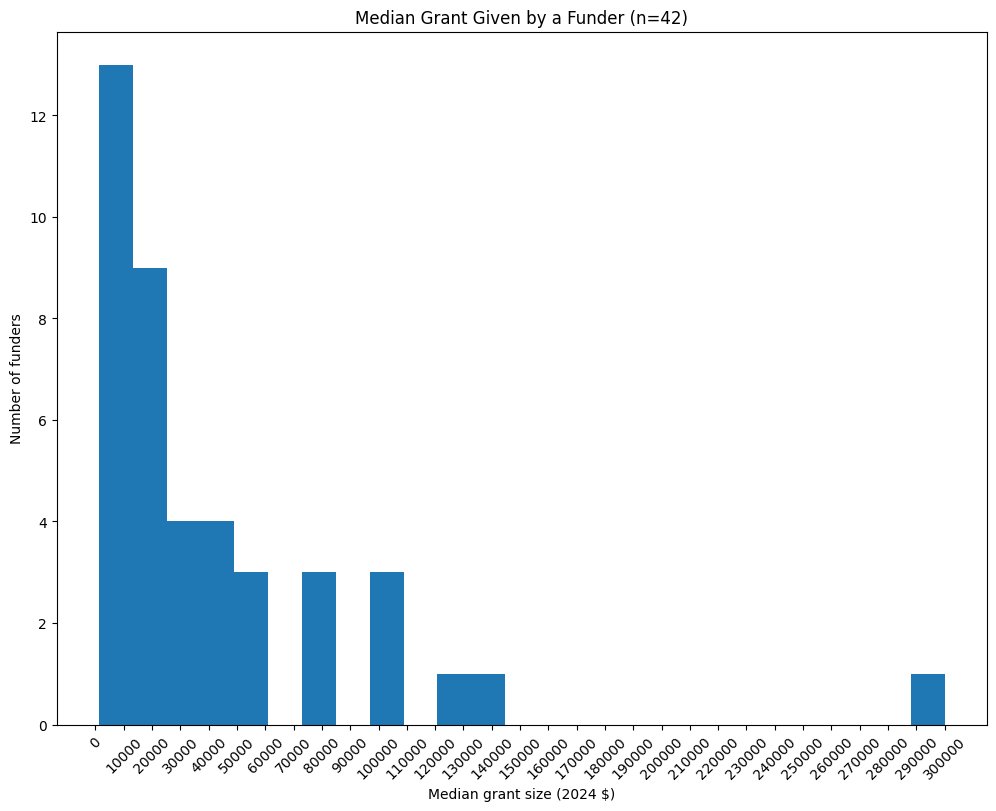

In [228]:
median_grant = funder_spending_merged.groupby("name").agg({"Median Grant Given":"first"}).reset_index()
median_grant = median_grant.drop(index=median_grant[median_grant["name"].isin(["Deutsche Bank Americas Foundation","Jerome L Greene Foundation Inc","Mizuho Usa Foundation Inc"])].index)

ax = plt.subplots(figsize=(12, 9))
plt.hist(median_grant["Median Grant Given"], bins=25)
plt.xticks(np.linspace(0,300000,31),rotation=45)
plt.title(f"Median Grant Given by a Funder (n={len(median_grant)})")
plt.xlabel("Median grant size (2024 $)")
plt.ylabel("Number of funders")
plt.show()

### Visualize total grant funding available in subsetted RSCF network funders over time
Note that this aggregation can change significantly based on which funders are included. This represents a version of the results based on the samples included here.

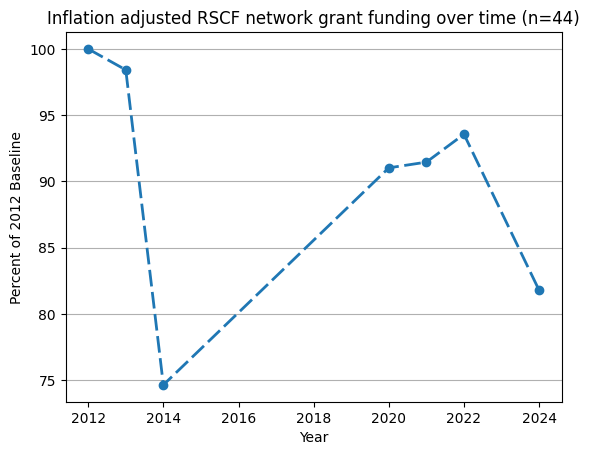

Funders included: ['Altman Foundation' 'Bernard And Anne Spitzer Charitable Tr'
 'Charles H Revson Foundation Inc' 'Cleveland H Dodge Foundation Inc'
 'Edwin Gould Foundation For Children' 'The Gramercy Park Foundation Inc'
 'Isaac H Tuttle Fund' 'Jandon Foundation'
 'J E & Z B Butler Foundation Inc' 'Jerome L Greene Foundation Inc'
 'Kpf Foundation' 'Lily Auchincloss Foundation Inc'
 'Mary J Hutchins Foundation Inc'
 'May And Samuel Rudin Family Foundation Inc' 'Mertz Gilmore Foundation'
 'Mizuho Usa Foundation Inc' 'Nancy And Edwin Marks Family Foundation'
 'New York Foundation' 'Pinkerton Foundation'
 'Planning And Art Resources For Communities Inc'
 'Robert Sterling Clark Foundation Inc' 'Shippy Foundation'
 'Solon E Summerfield Foundation Inc'
 'Stella And Charles Guttman Foundation Inc' 'A Woodner Fund Inc'
 'Achelis And Bodman Foundation' 'Barker Welfare Foundation'
 'The Carroll And Milton Petrie Foundation Inc'
 'Brodsky Family Foundation' 'The@Durst Family Foundation'
 'The E

,tax_prd_yr,contributions_inf,name,norm
1,2012,397048408.622046,44,1.0
2,2013,390766856.588237,44,0.984179
3,2014,296333534.923983,44,0.746341
8,2020,361400032.350426,44,0.910217
9,2021,363115613.376322,44,0.914537
10,2022,371474603.784087,44,0.93559
12,2024,324707094.90408,44,0.817802


In [237]:
spending_by_year = funder_spending_merged.groupby(["tax_prd_yr"]).agg({"contributions_inf":"sum","name":"count"}).reset_index()
spending_by_year = spending_by_year.drop(index = spending_by_year[spending_by_year["tax_prd_yr"].isin([2011,2015,2016,2018,2019,2023])].index)
spending_by_year["norm"] = spending_by_year["contributions_inf"] / spending_by_year["contributions_inf"].iloc[0]

# plot
fig, ax = plt.subplots()
x = spending_by_year["tax_prd_yr"]
y = spending_by_year["norm"] * 100
ax.plot(x, y, linewidth=2.0,dashes=[6, 2],marker = 'o')
plt.ylabel("Percent of 2012 Baseline")
plt.xlabel("Year")
plt.grid(axis="y")
plt.title(f"Inflation adjusted RSCF network grant funding over time (n={spending_by_year["name"].iloc[0]})")
plt.show()
print(f"Funders included: {funder_spending_merged["name"].unique()}")
spending_by_year

### Visualize individual or groups

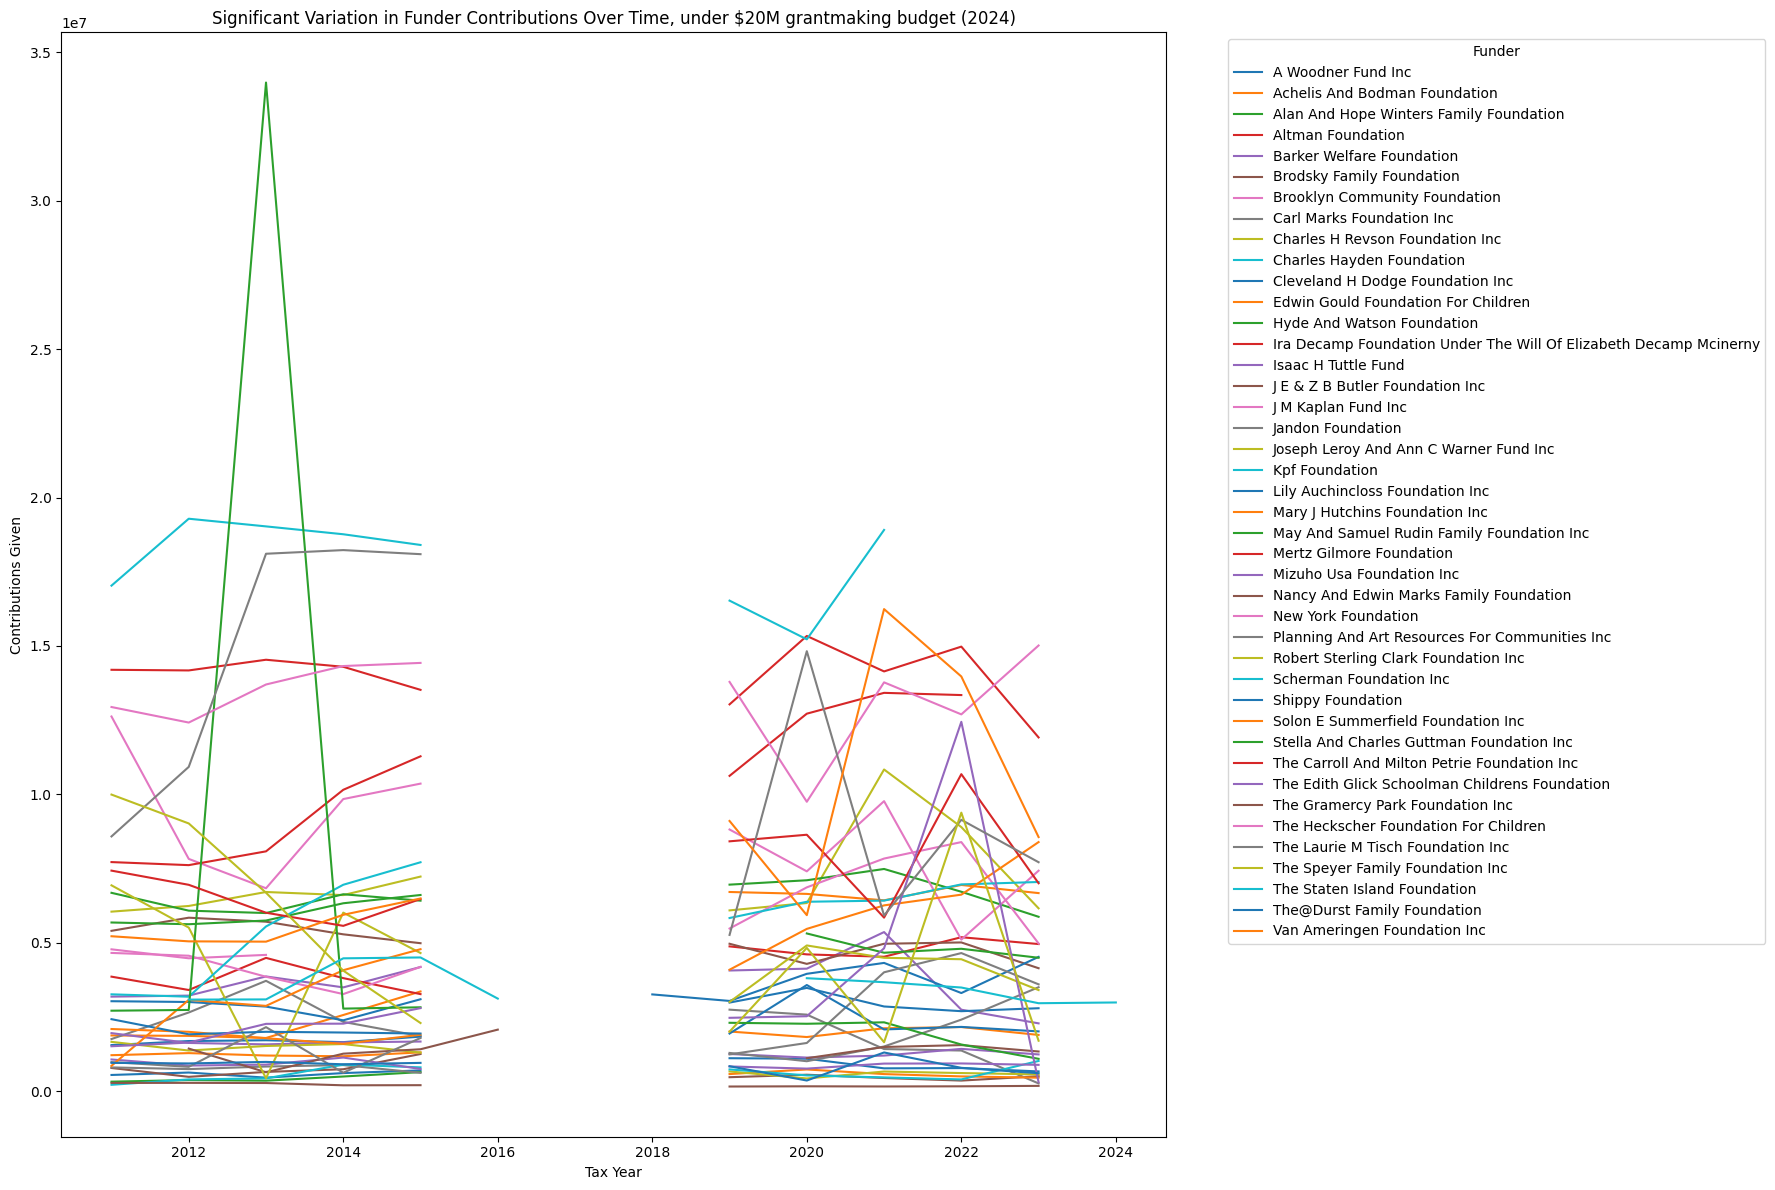

In [238]:
# Individual funder time series
# Group by funder and year
smaller = funder_spending_unf[funder_spending_unf["Contributions Given"] < 2e7]
df_grouped = smaller.groupby(["name", "tax_prd_yr"])["contributions_inf"].sum().reset_index()

# Pivot for plotting
df_pivot = df_grouped.pivot(index="tax_prd_yr", columns="name", values="contributions_inf")

# Plot
df_pivot.plot(kind="line", figsize=(18, 12))
plt.title("Significant Variation in Funder Contributions Over Time, under $20M grantmaking budget (2024)")
plt.xlabel("Tax Year")
plt.ylabel("Contributions Given")
plt.legend(title="Funder", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


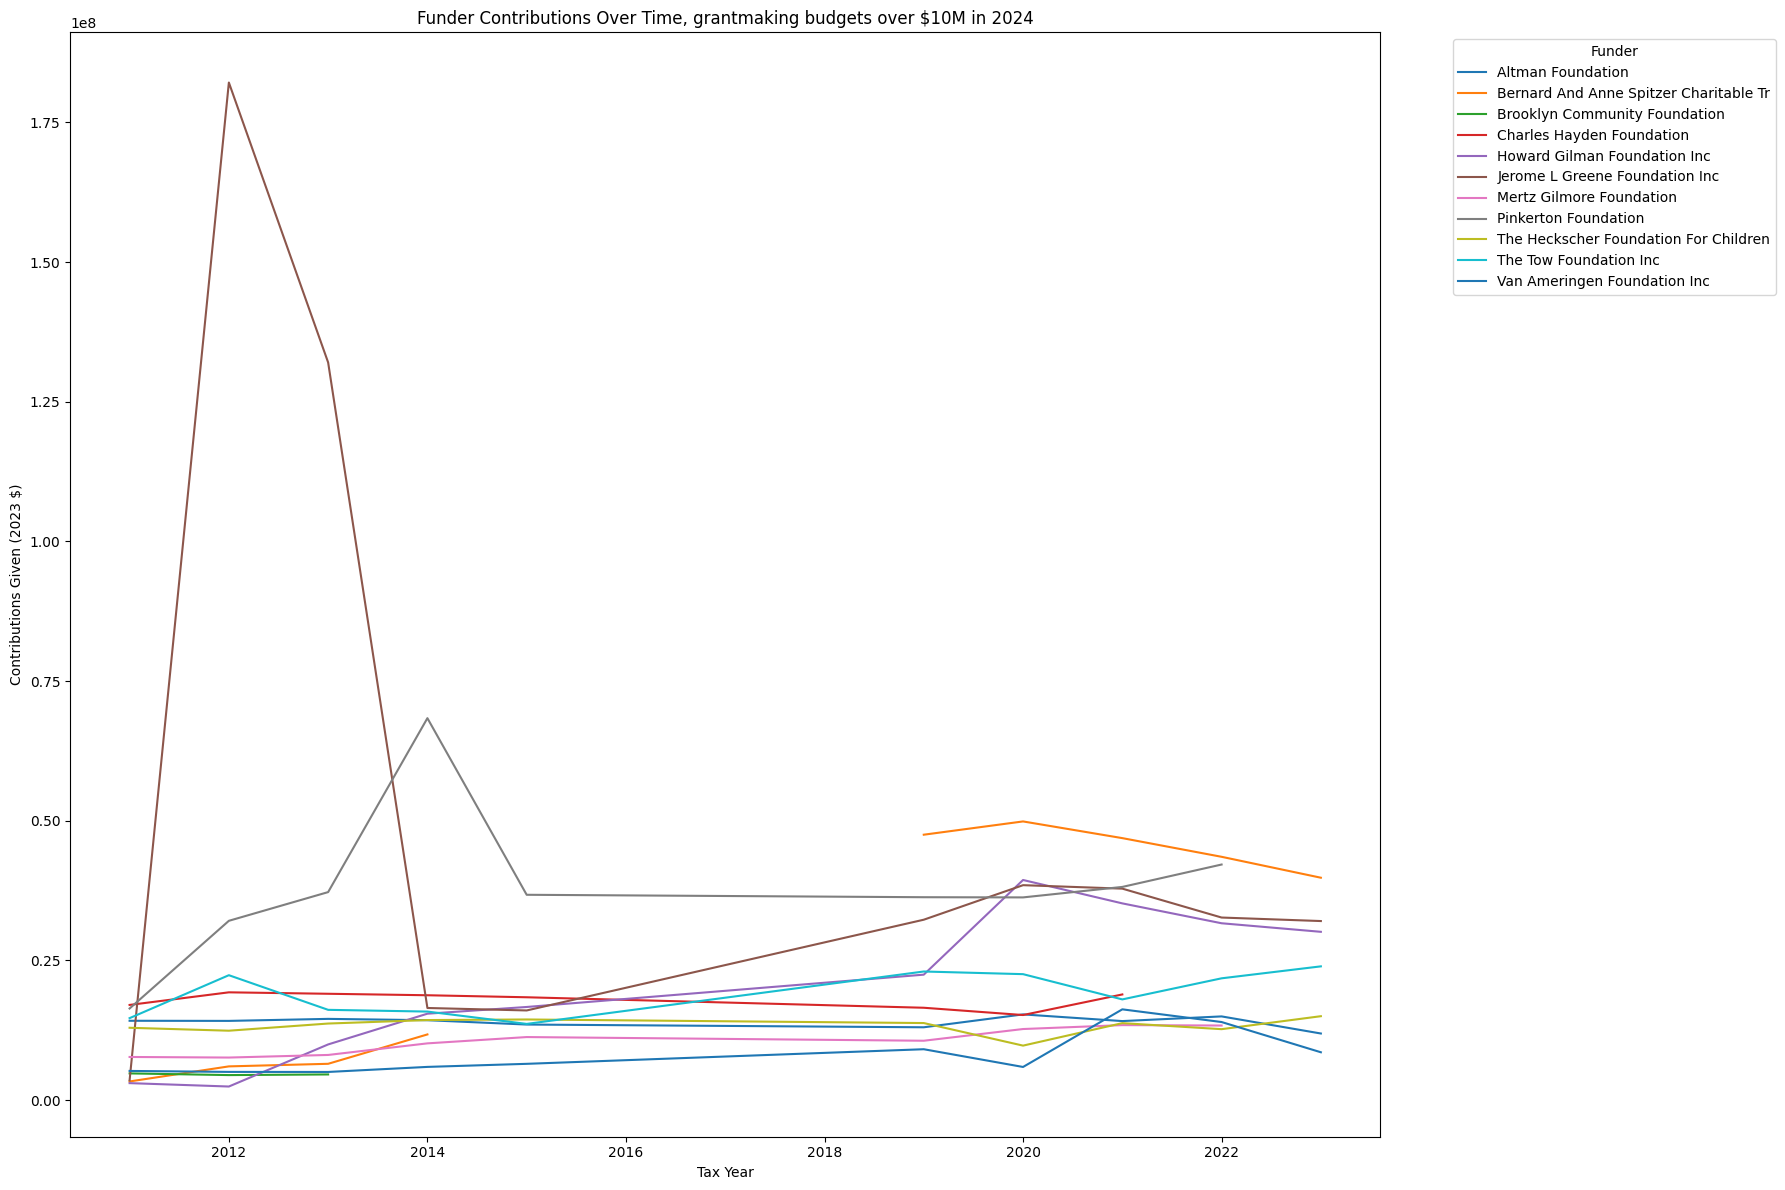

In [239]:
# Individual funder time series
# Group by funder and year
smaller = funder_spending_unf[funder_spending_unf["Contributions Given"] > 1e7]
df_grouped = smaller.groupby(["name", "tax_prd_yr"])["contributions_inf"].sum().reset_index()

# Pivot for plotting
df_pivot = df_grouped.pivot(index="tax_prd_yr", columns="name", values="contributions_inf")

# Plot
df_pivot.plot(kind="line", figsize=(18, 12))
plt.title("Funder Contributions Over Time, grantmaking budgets over $10M in 2024")
plt.xlabel("Tax Year")
plt.ylabel("Contributions Given (2023 $)")
plt.legend(title="Funder", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
